In [1]:
using ITensors, ITensorMPS, PolyChaos, Plots, Strided, LinearAlgebra, QuadGK
println(Threads.nthreads())

# pick one threading mode to avoid contention
BLAS.set_num_threads(4)
Strided.disable_threads()

# enable block-sparse threading if using QNs
ITensors.enable_threaded_blocksparse(false)

8


false

Variables

In [2]:
beta = 10 #inverse temperature 
mu = 0.0 #chemical potential
N = 50 #number of sites in each chain
Es = 0.0 #system site energy
D = 1. #bandwidth
g = 0.5 #system-bath coupling strength

0.5

In [3]:
function create_spectral(input::AbstractString, D, gauss) # (bool, amp, mean, sd)
    gaussian, amp, mean, sd = gauss

    # window
    inband = x -> (-D <= x <= D)

    # gaussian term
    G = gaussian ? (x -> amp * (1/(sd*sqrt(2pi))) * exp(-0.5*((x-mean)/sd)^2)) : (x -> 0.0)

    if input == "flat"
        J = x -> inband(x) ? 1/(2D) + G(x) : 0.0
    elseif input == "elliptical"
        J = x -> inband(x) ? sqrt(1 - (x/D)^2)+ G(x) : 0.0
    else
        error("spectral function type not recognized")
    end

    # normalization
    norm = quadgk(J, -D, D)[1]           
    # normalized callable
    Jnorm = x -> g*D/pi *J(x) / norm
    
    return Jnorm
end

fermi(k) = 1/(1 + exp(beta*k - beta*mu)) #fermi-dirac distribution

fermi (generic function with 1 method)

Spectral function, thermofield transformation of spectral function, orthogonal polynomial chain mapping

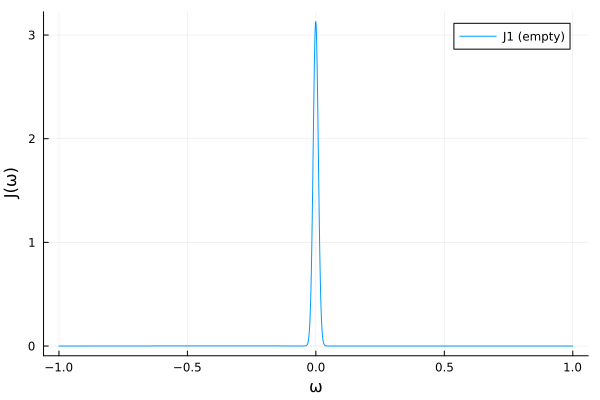

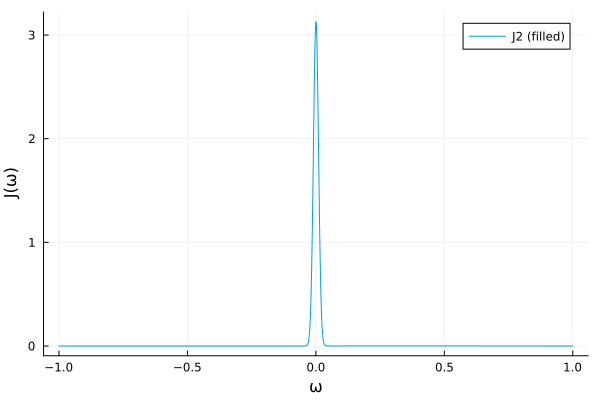

chain_map (generic function with 2 methods)

In [4]:
gauss = (true, 100, 0.0, 0.01)  #(bool, amp, mean, sd)
J = create_spectral("elliptical", D, gauss) #spectral function

J1(omega) = J(omega) * fermi(omega) #effective empty mode spectral density
J2(omega) = J(omega) * (1 - fermi(omega)) #effective filled mode spectral density
display(plot(x -> J1(x), -D, D, label="J1 (empty)", xlabel="ω", ylabel="J(ω)"))
display(plot(x -> J2(x), -D, D, label="J2 (filled)", xlabel="ω", ylabel="J(ω)"))
function chain_map(J, supp=(-D,D))
    """calculates family of monic orthogonal polynomials w.r.t the measure J(x) up to the Nth term.
    returns the coefficients alpha and beta from the recurrence relation of the family."""
    meas = Measure("bath", J, supp, false, Dict())
    ortho_poly = OrthoPoly("bath_op", N, meas; Nquad=2000)   
    AB = coeffs(ortho_poly)                                  
    return AB                             
end

generation and plotting of chain coefficients (site energies and hoppings)

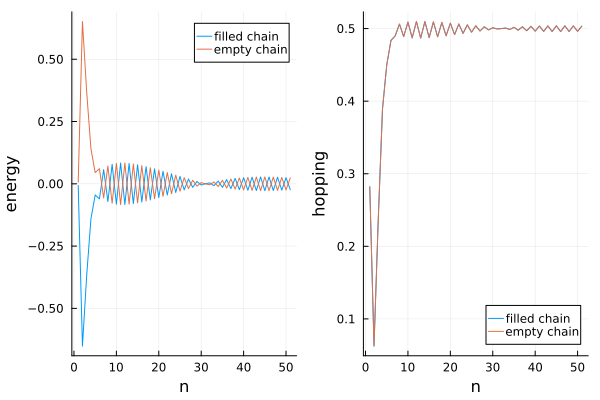

In [5]:
#println("norm is $J0")

chain1 = chain_map(J1) #coefficients from empty chain polynomials
chain2 = chain_map(J2) #coefficients from filled chain polynomials

energies1 = chain1[:,1] #on-site energies of empty chain
hopping1 = sqrt.(chain1[1:N+1,2]) #nearest neighbour hoppings of empty chain

energies2 = chain2[:,1] #on-site energies of filled chain
hopping2 = sqrt.(chain2[1:N+1,2]) #nearest neighbour hoppings of filled chain


p1 = plot(energies1, xlabel="n", ylabel="energy", label="filled chain")
plot!(p1, energies2, label="empty chain")
p2 = plot(hopping1, xlabel="n", ylabel="hopping", label="filled chain")
plot!(p2, hopping2, label="empty chain")

display(plot(p1,p2))


creation of initial state MPS and Hamiltonian MPO

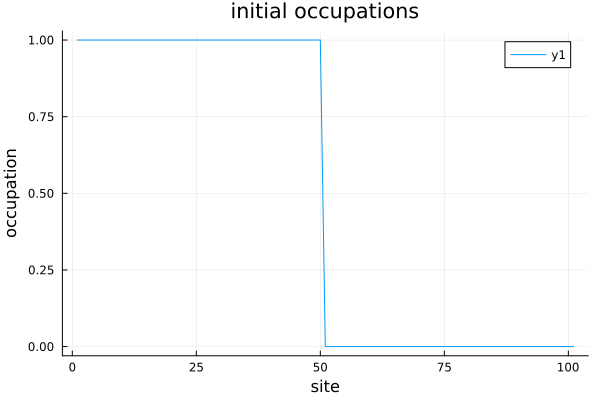

Hamiltonian (generic function with 1 method)

In [6]:
sys = N+1
theta = pi/2 #initial system superposition 

sites = siteinds("Fermion", 2*N+1, conserve_qns=true) #assuming that truncated bath remains approximately closed within simulation time

states = [(j <= N) ? "Occ" : "Emp" for j=1:2*N+1]

psi0 = productMPS(sites, states)

init_occ = expect(psi0, "N")
display(plot(1:(2N+1), init_occ,xlabel="site",ylabel="occupation",title="initial occupations"))

function Hamiltonian(E1, E2, h1, h2, sites, Es, N, sys)
    ampo = AutoMPO()
    g1 = hopping1[1]
    g2 = hopping2[1]
    t1 = reverse(h1[2:end]) #empty chain NN couplings
    E1 = reverse(E1) #empty chain onsite energies
    t2 = h2[2:end] #filled chain NN couplings
    
    for j in 1:N
        add!(ampo, E1[j], "N", j)
    end
    for j in 1:N-1
        add!(ampo, t1[j], "Cdag", j, "C", j+1)
        add!(ampo, t1[j], "Cdag", j+1, "C", j)
    end
    for j in 1:N
        add!(ampo, E2[j], "N", sys + j)
    end
    for j in 1:N-1
        add!(ampo, t2[j], "Cdag", sys + j, "C", sys + j + 1)
        add!(ampo, t2[j], "Cdag", sys + j + 1, "C", sys + j)
    end
    # system onsite
    add!(ampo, Es, "N", sys)
    add!(ampo, g1, "Cdag", sys, "C", N);         add!(ampo, g1, "Cdag", N, "C", sys)
    add!(ampo, g2, "Cdag", sys, "C", sys + 1);    add!(ampo, g2, "Cdag", sys + 1,  "C", sys)
   
    return MPO(ampo, sites)
end

TDVP time evolution of MPS via Hamiltonian MPO

timestep 1 of 400 complete
timestep 2 of 400 complete
timestep 3 of 400 complete
timestep 4 of 400 complete
timestep 5 of 400 complete
timestep 6 of 400 complete
timestep 7 of 400 complete
timestep 8 of 400 complete
timestep 9 of 400 complete
timestep 10 of 400 complete
timestep 11 of 400 complete
timestep 12 of 400 complete
timestep 13 of 400 complete
timestep 14 of 400 complete
timestep 15 of 400 complete
timestep 16 of 400 complete
timestep 17 of 400 complete
timestep 18 of 400 complete
timestep 19 of 400 complete
timestep 20 of 400 complete
timestep 21 of 400 complete
timestep 22 of 400 complete
timestep 23 of 400 complete
timestep 24 of 400 complete
timestep 25 of 400 complete
timestep 26 of 400 complete
timestep 27 of 400 complete
timestep 28 of 400 complete
timestep 29 of 400 complete
timestep 30 of 400 complete
timestep 31 of 400 complete
timestep 32 of 400 complete
timestep 33 of 400 complete
timestep 34 of 400 complete
timestep 35 of 400 complete
timestep 36 of 400 complete
t

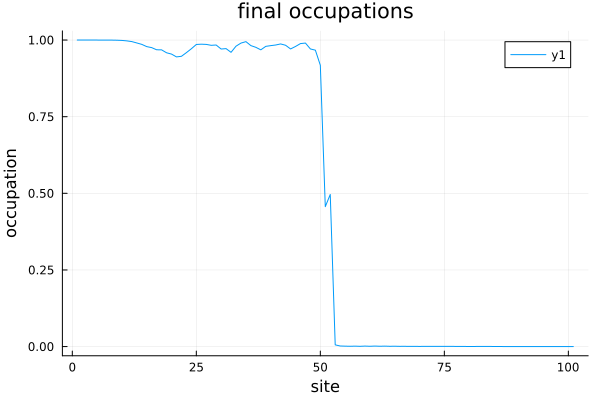

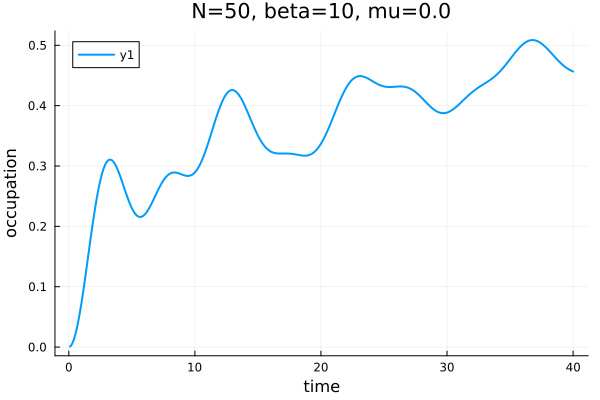

In [7]:
sweeps = Sweeps(2); maxdim!(sweeps, 400, 800); cutoff!(sweeps, 1e-9)
H = Hamiltonian(energies1, energies2, hopping1, hopping2, sites, 0.0, N, sys)
let
    psi = psi0
    dt = 0.1
    tmax = 40
    ts = collect(dt:dt:tmax)
    len = length(ts)
    nSys = zeros(len)
    num = zeros(2N+1)
    av_occ = zeros(len)    
    for k in 1:len
        psi = ITensorMPS.tdvp(H, -im*dt, psi;nsite=2, outputlevel=0,mindim=1, maxdim=100); #time_step=dt, nsweeps=sweeps, order=2)
        num = expect(psi, "N")
        nSys[k] = num[sys]
        #av_occ[k] = sum(num) / (2N+1)
        println("timestep $k of $len complete")
    end
    display(plot(1:(2N+1),num,xlabel="site",ylabel="occupation",title="final occupations"))
    display(plot(ts,nSys,xlabel="time",ylabel="occupation",title="N=$N, beta=$beta, mu=$mu", lw=2))
    #display(plot(ts,av_occ,xlabel="time",ylabel="average occupation",title="N=$N, beta=$beta, mu=$mu"))
end